<a href="https://colab.research.google.com/github/vcwild/rnn-bike-predict/blob/main/time_series_rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import GRU

plt.style.use('seaborn-whitegrid')
plt.rcParams['figure.figsize'] = (10,6)
plt.rcParams['font.size'] = 20

## Define lag data function

In [2]:
def lag_data(vector, n_steps):
  X, y = [], []

  for i in range(n_steps, vector.shape[0]):
    X.append(list(vector.loc[i-n_steps:i-1]))
    y.append(vector.loc[i])
  X, y = np.array(X), np.array(y)
  return X, y

## Data transformations

In [3]:
df = pd.read_csv('bike_sharing.csv', parse_dates=True)

In [4]:
df.head()

,date,count,temp,sensation,humidity,windspeed,weather,holiday,weekend,season
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


In [5]:
df['date'] = pd.to_datetime(df['date'])

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


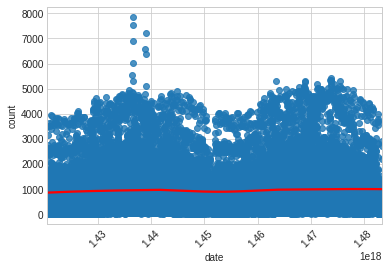

In [6]:
sns.regplot(x=df['date'].astype(int), y='count', data=df, lowess=True, line_kws={'color': 'red'})
plt.xticks(rotation=45);

# Preprocessing

## Scaling

In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaler.fit(df['count'].values.reshape(-1, 1))
y = scaler.transform(df['count'].values.reshape(-1, 1))

# Train-test split

In [8]:
train_ratio = 0.9
train_size = int(len(df) * train_ratio)
test_size = 1 - train_size

y_train = y[:train_size]
y_test = y[train_size:]

In [9]:
train_size

15672

In [10]:
y_train

array([[-0.88574518],
       [-0.9262953 ],
       [-0.92998167],
       ...,
       [-0.9548647 ],
       [-0.9548647 ],
       [-0.89403952]])

In [11]:
len(y_train) + len(y_test)

17414

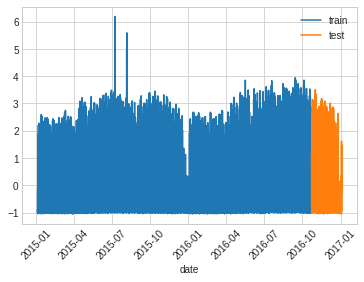

In [12]:
sns.lineplot(x=df[:len(y_train)]['date'], y=y_train.flatten(), label='train')
sns.lineplot(x=df[len(y_train):]['date'], y=y_test.flatten(), label='test')
plt.xticks(rotation=45);

## Split data using 10 lags

In [13]:
vector = pd.DataFrame(y_train)[0]
lags = 10
X_train, y_train = lag_data(vector, lags)

In [14]:
vector_test = pd.DataFrame(y_test)[0]
X_test, y_test = lag_data(vector_test, lags)

# Using Recurrent Neural Networks (RNN)

### Reshape data to 3D
Last param (1) is the number of features in space-time ("count")

In [15]:
X_train_reshape = X_train.reshape((X_train.shape[0], X_train.shape[1],1)) 
X_test_reshape = X_test.reshape((X_test.shape[0], X_test.shape[1],1))

## Long Short Term Memory (LSTM)
RMSProp --> Avoid exploding gradient for weight estimators

In [16]:
recurrent = Sequential()

recurrent.add(LSTM(128, input_shape=(X_train_reshape.shape[1], X_train_reshape.shape[2]))) # Pass 2nd and 3rd dimensions from the input matrix
recurrent.add(Dense(units=1))

In [17]:
recurrent.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               66560     
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________


In [18]:
recurrent.compile(optimizer='RMSProp', loss='mean_squared_error')
results = recurrent.fit(X_train_reshape, y_train, validation_data=(X_test_reshape, y_test), epochs=20)

Epoch 1/20
490/490 [==============================] - 6s 12ms/step - loss: 0.2419 - val_loss: 0.0875
Epoch 2/20
490/490 [==============================] - 5s 11ms/step - loss: 0.0783 - val_loss: 0.0585
Epoch 3/20
490/490 [==============================] - 5s 11ms/step - loss: 0.0552 - val_loss: 0.0399
Epoch 4/20
490/490 [==============================] - 5s 11ms/step - loss: 0.0469 - val_loss: 0.0342
Epoch 5/20
490/490 [==============================] - 6s 11ms/step - loss: 0.0427 - val_loss: 0.0249
Epoch 6/20
490/490 [==============================] - 5s 11ms/step - loss: 0.0391 - val_loss: 0.0396
Epoch 7/20
490/490 [==============================] - 5s 11ms/step - loss: 0.0372 - val_loss: 0.0209
Epoch 8/20
490/490 [==============================] - 5s 11ms/step - loss: 0.0355 - val_loss: 0.0195
Epoch 9/20
490/490 [==============================] - 5s 11ms/step - loss: 0.0337 - val_loss: 0.0197
Epoch 10/20
490/490 [==============================] - 5s 11ms/step - loss: 0.0324 - val_lo

In [19]:
y_fit = recurrent.predict(X_train_reshape)

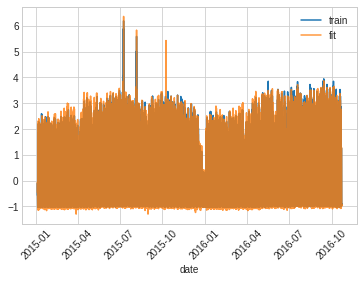

In [20]:
sns.lineplot(x=df[:len(y_train)]['date'], y=y_train, label='train')
sns.lineplot(x=df[:len(y_train)]['date'], y=y_fit.flatten(), label='fit', alpha=0.8)
plt.xticks(rotation=45);

In [21]:
y_predict = recurrent.predict(X_test_reshape)

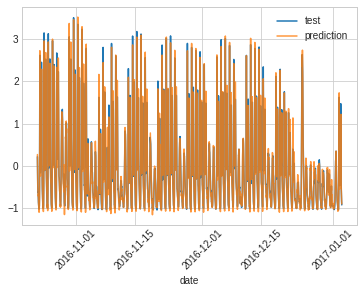

In [22]:
sns.lineplot(x=df[len(y_train):len(df)-20]['date'], y=y_test, label='test')
sns.lineplot(x=df[len(y_train):len(df)-20]['date'], y=y_predict.flatten(), label='prediction', alpha=0.8)
plt.xticks(rotation=45);

## Gated Recurrent Unit (GRU)

In [23]:
recurrent_2 = Sequential()

recurrent_2.add(GRU(128, input_shape=(X_train_reshape.shape[1], X_train_reshape.shape[2])))
recurrent_2.add(Dense(units=1))

In [24]:
recurrent_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 128)               50304     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 50,433
Trainable params: 50,433
Non-trainable params: 0
_________________________________________________________________


In [25]:
recurrent_2.compile(optimizer='RMSProp', loss='mean_squared_error')
results_2 = recurrent_2.fit(X_train_reshape, y_train, validation_data=(X_test_reshape, y_test), epochs=20)

Epoch 1/20
490/490 [==============================] - 5s 10ms/step - loss: 0.2278 - val_loss: 0.0522
Epoch 2/20
490/490 [==============================] - 5s 10ms/step - loss: 0.0658 - val_loss: 0.0368
Epoch 3/20
490/490 [==============================] - 5s 10ms/step - loss: 0.0488 - val_loss: 0.0449
Epoch 4/20
490/490 [==============================] - 5s 10ms/step - loss: 0.0419 - val_loss: 0.0229
Epoch 5/20
490/490 [==============================] - 5s 10ms/step - loss: 0.0375 - val_loss: 0.0222
Epoch 6/20
490/490 [==============================] - 5s 10ms/step - loss: 0.0357 - val_loss: 0.0238
Epoch 7/20
490/490 [==============================] - 5s 10ms/step - loss: 0.0339 - val_loss: 0.0253
Epoch 8/20
490/490 [==============================] - 5s 10ms/step - loss: 0.0326 - val_loss: 0.0260
Epoch 9/20
490/490 [==============================] - 5s 10ms/step - loss: 0.0313 - val_loss: 0.0201
Epoch 10/20
490/490 [==============================] - 5s 10ms/step - loss: 0.0310 - val_lo

In [26]:
y_predict_2 = recurrent_2.predict(X_test_reshape)

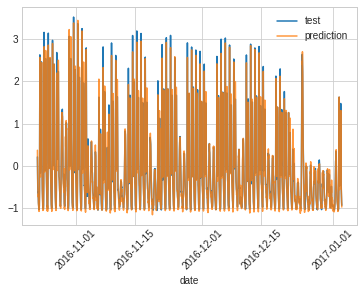

In [27]:
sns.lineplot(x=df[len(y_train):len(df)-20]['date'], y=y_test, label='test')
sns.lineplot(x=df[len(y_train):len(df)-20]['date'], y=y_predict_2.flatten(), label='prediction', alpha=0.8)
plt.xticks(rotation=45);

## Compare Models

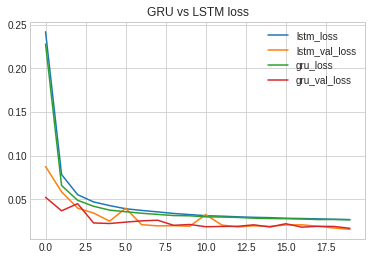

In [28]:
plt.plot(results.history['loss'], label='lstm_loss')
plt.plot(results.history['val_loss'], label='lstm_val_loss')
plt.plot(results_2.history['loss'], label='gru_loss')
plt.plot(results_2.history['val_loss'], label='gru_val_loss')
plt.legend()
plt.title('GRU vs LSTM loss');